In [1]:
import torch
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import time
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

from srgan import Generator, Discriminator, GeneratorLoss

import sys
sys.path.append('../')
from custom_image_dataset import CustomImageDataset
from image_helper import ImageHelper
from model_runner import ModelRunner

import image_patches

from SRCNN import SRCNN
sys.path.append('../DBPN/')
from DBPN_copied import DBPN


In [2]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [4]:
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 128 # 32 * 4

PATCHES_PER_IMAGE_TRAIN = 30 #####
# PATCHES_PER_IMAGE_TRAIN = 10
PATCHES_PER_IMAGE_VALIDATION = 20 #####
# PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


 87%|████████▋ | 2549/2920 [01:39<00:12, 28.58it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: Out of bound read in decode_png. Probably, the input image is corrupted


100%|██████████| 2920/2920 [01:53<00:00, 25.62it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:16<00:00, 39.26it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 40min 8s, sys: 19.2 s, total: 1h 40min 28s
Wall time: 2min 20s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1.25*(2**7))

num_workers = 0

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers)

CPU times: user 1.21 s, sys: 316 ms, total: 1.52 s
Wall time: 1.52 s


In [8]:
netG = Generator(UPSCALE_FACTOR).to(device)
netD = Discriminator().to(device)
generator_criterion = GeneratorLoss().to(device)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [10]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

d_loss_array = []
g_loss_array = []
d_score_array = []
g_score_array = []


In [11]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results


In [12]:
model_runner = ModelRunner()

# Lists to store training and validation losses
train_losses = []
val_losses = []
discriminator_losses = []
time_array = []
epoch_array = []
lr_array = []

# Initialize tqdm progress bar for the entire training process
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    epoch_array.append(epoch)
    lr_array.append(optimizerG.param_groups[0]['lr'])

    start_time = time.time()


    running_results = {'batch_sizes': 0, 'd_loss': 0,
                    "g_loss": 0, "d_score": 0, "g_score": 0}

    netG.train()
    netD.train()
    for data, target in train_dataloader:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        # Move real images and noise vectors to the device
        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        # Generate fake images using the generator
        fake_img = netG(z)
        # Zero out the gradients of the discriminator
        netD.zero_grad()

        # Compute the discriminator scores for real and fake images
        real_out = netD(real_img).mean()        
        fake_out = netD(fake_img).mean()

        # Calculate the discriminator loss
        d_loss = 1 - real_out + fake_out

        # Backpropagate the discriminator loss and update its parameters
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator ##
        # Generate fake images again using the updated generator
        fake_img = netG(z)
        # Compute the discriminator score for the generated fake images
        fake_out = netD(fake_img).mean()

        # Zero out the gradients of the generator
        netG.zero_grad()

        # Calculate the generator loss using a predefined criterion
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        
        # Backpropagate the generator loss and update its parameters
        g_loss.backward()
        optimizerG.step()


        # Update the running results with batch-wise metrics
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size # TODO: check if this is correct (fake_out.item() * batch_size maybe?)


        ##### my code #####
        g_loss_array.append(g_loss.item())
        d_loss_array.append(d_loss.item())
        d_score_array.append(real_out.item())
        g_score_array.append(fake_out.item())
        ###################

    # Validation loop
    netG.eval()
    netD.eval()
    val_loss = 0

    # Iterate through each batch in the validation dataloader
    with torch.no_grad():
        for val_data, val_target in validation_dataloader:
            val_batch_size = val_data.size(0)
            real_img_val = Variable(val_target).to(device)
            z_val = Variable(val_data).to(device)

            fake_img_val = netG(z_val)
            fake_out_val = netD(fake_img_val).mean()

            # Calculate validation loss
            val_loss += generator_criterion(fake_out_val, fake_img_val, real_img_val).item()
        
        # Calculate average validation loss
        # avg_val_loss = val_loss # old and I think wrong
        avg_val_loss = val_loss / len(validation_dataloader) # TODO: new and I think correct
        val_losses.append(avg_val_loss)

    end_time = time.time() - start_time
    time_array.append(end_time)

    # Update the tqdm progress bar to show relevant information
    tqdm.write(
        "[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f Val Loss: %.4f Time: %.4f"
        % (
            epoch + 1, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes'],
            avg_val_loss,
            end_time
        ))
    
    # Store training loss for plotting
    train_losses.append(running_results['g_loss'] / running_results['batch_sizes'])

    discriminator_losses.append(running_results['d_loss'] / running_results['batch_sizes'])




Epochs:   0%|          | 0/150 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epochs:   1%|          | 1/150 [05:15<13:02:24, 315.07s/it]

[1/150] Loss_D: 0.1134 Loss_G: 0.0085 D(x): 0.9585 D(G(z)): 0.0673 Val Loss: 0.5287 Time: 315.0629


Epochs:   1%|▏         | 2/150 [10:29<12:56:56, 314.98s/it]

[2/150] Loss_D: 0.2224 Loss_G: 0.0062 D(x): 0.8591 D(G(z)): 0.0798 Val Loss: 0.4556 Time: 314.9092


Epochs:   2%|▏         | 3/150 [15:45<12:52:14, 315.20s/it]

[3/150] Loss_D: 0.0533 Loss_G: 0.0060 D(x): 0.9619 D(G(z)): 0.0129 Val Loss: 0.4617 Time: 315.4731


Epochs:   3%|▎         | 4/150 [21:00<12:46:28, 314.99s/it]

[4/150] Loss_D: 0.0001 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4428 Time: 314.6531


Epochs:   3%|▎         | 5/150 [26:14<12:41:03, 314.92s/it]

[5/150] Loss_D: 0.0001 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4383 Time: 314.7975


Epochs:   4%|▍         | 6/150 [31:29<12:35:45, 314.90s/it]

[6/150] Loss_D: 0.0017 Loss_G: 0.0056 D(x): 0.9990 D(G(z)): 0.0005 Val Loss: 0.4236 Time: 314.8593


Epochs:   5%|▍         | 7/150 [36:43<12:29:43, 314.57s/it]

[7/150] Loss_D: 0.0000 Loss_G: 0.0055 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4174 Time: 313.8853


Epochs:   5%|▌         | 8/150 [41:57<12:23:44, 314.25s/it]

[8/150] Loss_D: 0.0000 Loss_G: 0.0055 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4114 Time: 313.5767


Epochs:   6%|▌         | 9/150 [47:11<12:18:17, 314.16s/it]

[9/150] Loss_D: 0.0000 Loss_G: 0.0054 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4120 Time: 313.9629


Epochs:   7%|▋         | 10/150 [52:25<12:13:06, 314.19s/it]

[10/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4200 Time: 314.2382


Epochs:   7%|▋         | 11/150 [57:39<12:07:52, 314.19s/it]

[11/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4196 Time: 314.1901


Epochs:   8%|▊         | 12/150 [1:02:53<12:02:14, 314.02s/it]

[12/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0002 Val Loss: 0.3975 Time: 313.6319


Epochs:   9%|▊         | 13/150 [1:08:07<11:56:54, 313.97s/it]

[13/150] Loss_D: 0.9992 Loss_G: 0.0051 D(x): 0.1835 D(G(z)): 0.1800 Val Loss: 0.4009 Time: 313.8656


Epochs:   9%|▉         | 14/150 [1:13:21<11:51:40, 313.97s/it]

[14/150] Loss_D: 1.0000 Loss_G: 0.0052 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3929 Time: 313.9646


Epochs:  10%|█         | 15/150 [1:18:35<11:46:38, 314.06s/it]

[15/150] Loss_D: 1.0000 Loss_G: 0.0052 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3937 Time: 314.2686


Epochs:  11%|█         | 16/150 [1:23:49<11:41:29, 314.10s/it]

[16/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3951 Time: 314.1873


Epochs:  11%|█▏        | 17/150 [1:29:03<11:36:11, 314.07s/it]

[17/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3984 Time: 313.9957


Epochs:  12%|█▏        | 18/150 [1:34:17<11:31:05, 314.13s/it]

[18/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3959 Time: 314.2670


Epochs:  13%|█▎        | 19/150 [1:39:32<11:25:54, 314.16s/it]

[19/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.4724 Time: 314.2156


Epochs:  13%|█▎        | 20/150 [1:44:46<11:20:44, 314.19s/it]

[20/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.4020 Time: 314.2612


Epochs:  14%|█▍        | 21/150 [1:50:00<11:15:28, 314.17s/it]

[21/150] Loss_D: 1.0000 Loss_G: 0.0051 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3866 Time: 314.1349


Epochs:  15%|█▍        | 22/150 [1:55:14<11:10:16, 314.19s/it]

[22/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3896 Time: 314.2294


Epochs:  15%|█▌        | 23/150 [2:00:28<11:04:48, 314.08s/it]

[23/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3887 Time: 313.8262


Epochs:  16%|█▌        | 24/150 [2:05:42<10:59:41, 314.14s/it]

[24/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3846 Time: 314.2678


Epochs:  17%|█▋        | 25/150 [2:10:56<10:54:07, 313.98s/it]

[25/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3909 Time: 313.6109


Epochs:  17%|█▋        | 26/150 [2:16:10<10:49:00, 314.03s/it]

[26/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3865 Time: 314.1562


Epochs:  18%|█▊        | 27/150 [2:21:24<10:44:00, 314.15s/it]

[27/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3862 Time: 314.4049


Epochs:  19%|█▊        | 28/150 [2:26:39<10:38:44, 314.13s/it]

[28/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3867 Time: 314.1008


Epochs:  19%|█▉        | 29/150 [2:31:53<10:33:37, 314.19s/it]

[29/150] Loss_D: 1.0000 Loss_G: 0.0050 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3811 Time: 314.3322


Epochs:  20%|██        | 30/150 [2:37:07<10:28:22, 314.19s/it]

[30/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3979 Time: 314.1723


Epochs:  21%|██        | 31/150 [2:42:21<10:23:05, 314.16s/it]

[31/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3845 Time: 314.0954


Epochs:  21%|██▏       | 32/150 [2:47:35<10:17:50, 314.15s/it]

[32/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3810 Time: 314.1317


Epochs:  22%|██▏       | 33/150 [2:52:50<10:12:39, 314.18s/it]

[33/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3799 Time: 314.2421


Epochs:  23%|██▎       | 34/150 [2:58:04<10:07:34, 314.27s/it]

[34/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3844 Time: 314.4598


Epochs:  23%|██▎       | 35/150 [3:03:18<10:02:11, 314.19s/it]

[35/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3774 Time: 314.0039


Epochs:  24%|██▍       | 36/150 [3:08:33<9:57:08, 314.29s/it] 

[36/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3785 Time: 314.5235


Epochs:  25%|██▍       | 37/150 [3:13:46<9:51:38, 314.14s/it]

[37/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3781 Time: 313.7969


Epochs:  25%|██▌       | 38/150 [3:19:00<9:46:14, 314.06s/it]

[38/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3789 Time: 313.8635


Epochs:  26%|██▌       | 39/150 [3:24:15<9:41:12, 314.16s/it]

[39/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3757 Time: 314.4054


Epochs:  27%|██▋       | 40/150 [3:29:29<9:35:54, 314.13s/it]

[40/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3943 Time: 314.0457


Epochs:  27%|██▋       | 41/150 [3:34:43<9:30:41, 314.14s/it]

[41/150] Loss_D: 1.0000 Loss_G: 0.0049 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3739 Time: 314.1575


Epochs:  28%|██▊       | 42/150 [3:39:57<9:25:16, 314.04s/it]

[42/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3869 Time: 313.8171


Epochs:  29%|██▊       | 43/150 [3:45:11<9:20:09, 314.11s/it]

[43/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3821 Time: 314.2514


Epochs:  29%|██▉       | 44/150 [3:50:25<9:14:56, 314.12s/it]

[44/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3754 Time: 314.1364


Epochs:  30%|███       | 45/150 [3:55:39<9:09:45, 314.14s/it]

[45/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3730 Time: 314.2053


Epochs:  31%|███       | 46/150 [4:00:53<9:04:28, 314.12s/it]

[46/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3750 Time: 314.0539


Epochs:  31%|███▏      | 47/150 [4:06:07<8:59:10, 314.09s/it]

[47/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3737 Time: 314.0099


Epochs:  32%|███▏      | 48/150 [4:11:22<8:54:02, 314.14s/it]

[48/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.4179 Time: 314.2754


Epochs:  33%|███▎      | 49/150 [4:16:36<8:48:50, 314.16s/it]

[49/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3708 Time: 314.2067


Epochs:  33%|███▎      | 50/150 [4:21:50<8:43:37, 314.17s/it]

[50/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3751 Time: 314.1922


Epochs:  34%|███▍      | 51/150 [4:27:04<8:38:29, 314.23s/it]

[51/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3697 Time: 314.3727


Epochs:  35%|███▍      | 52/150 [4:32:19<8:33:20, 314.29s/it]

[52/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3717 Time: 314.4084


Epochs:  35%|███▌      | 53/150 [4:37:32<8:27:37, 314.00s/it]

[53/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3757 Time: 313.3224


Epochs:  36%|███▌      | 54/150 [4:42:46<8:22:15, 313.91s/it]

[54/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3701 Time: 313.7023


Epochs:  37%|███▋      | 55/150 [4:48:00<8:17:07, 313.97s/it]

[55/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3699 Time: 314.1164


Epochs:  37%|███▋      | 56/150 [4:53:14<8:11:51, 313.96s/it]

[56/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3725 Time: 313.9095


Epochs:  38%|███▊      | 57/150 [4:58:28<8:06:32, 313.89s/it]

[57/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3774 Time: 313.7475


Epochs:  39%|███▊      | 58/150 [5:03:41<8:01:17, 313.88s/it]

[58/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3720 Time: 313.8546


Epochs:  39%|███▉      | 59/150 [5:08:55<7:55:46, 313.70s/it]

[59/150] Loss_D: 1.0000 Loss_G: 0.0048 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3698 Time: 313.2732


Epochs:  40%|████      | 60/150 [5:14:08<7:50:32, 313.69s/it]

[60/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3700 Time: 313.6601


Epochs:  41%|████      | 61/150 [5:19:22<7:45:25, 313.77s/it]

[61/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3701 Time: 313.9421


Epochs:  41%|████▏     | 62/150 [5:24:37<7:40:25, 313.93s/it]

[62/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3838 Time: 314.3105


Epochs:  42%|████▏     | 63/150 [5:29:51<7:35:26, 314.09s/it]

[63/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 0.0000 D(G(z)): 0.0000 Val Loss: 0.3686 Time: 314.4670


Epochs:  43%|████▎     | 64/150 [5:35:05<7:30:13, 314.11s/it]

[64/150] Loss_D: 0.9995 Loss_G: 0.0046 D(x): 0.1760 D(G(z)): 0.1760 Val Loss: 0.3428 Time: 314.1597


Epochs:  43%|████▎     | 65/150 [5:40:19<7:24:57, 314.09s/it]

[65/150] Loss_D: 0.9764 Loss_G: 0.0044 D(x): 0.3830 D(G(z)): 0.3573 Val Loss: 0.3473 Time: 314.0271


Epochs:  44%|████▍     | 66/150 [5:45:34<7:19:55, 314.24s/it]

[66/150] Loss_D: 0.6481 Loss_G: 0.0046 D(x): 0.6809 D(G(z)): 0.3124 Val Loss: 0.3676 Time: 314.5758


Epochs:  45%|████▍     | 67/150 [5:50:48<7:14:41, 314.24s/it]

[67/150] Loss_D: 0.0178 Loss_G: 0.0047 D(x): 0.9984 D(G(z)): 0.0152 Val Loss: 0.3596 Time: 314.2369


Epochs:  45%|████▌     | 68/150 [5:56:03<7:09:33, 314.31s/it]

[68/150] Loss_D: 0.0003 Loss_G: 0.0047 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.3677 Time: 314.4816


Epochs:  46%|████▌     | 69/150 [6:01:16<7:04:07, 314.17s/it]

[69/150] Loss_D: 0.0031 Loss_G: 0.0047 D(x): 0.9985 D(G(z)): 0.0009 Val Loss: 0.3662 Time: 313.8266


Epochs:  47%|████▋     | 70/150 [6:06:31<6:58:58, 314.23s/it]

[70/150] Loss_D: 0.0004 Loss_G: 0.0047 D(x): 0.9999 D(G(z)): 0.0002 Val Loss: 0.3681 Time: 314.3731


Epochs:  47%|████▋     | 71/150 [6:11:45<6:53:45, 314.25s/it]

[71/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3661 Time: 314.2789


Epochs:  48%|████▊     | 72/150 [6:16:59<6:48:34, 314.28s/it]

[72/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3687 Time: 314.3733


Epochs:  49%|████▊     | 73/150 [6:22:14<6:43:14, 314.21s/it]

[73/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3672 Time: 314.0365


Epochs:  49%|████▉     | 74/150 [6:27:28<6:37:57, 314.18s/it]

[74/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3764 Time: 314.0960


Epochs:  50%|█████     | 75/150 [6:32:42<6:32:50, 314.27s/it]

[75/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3696 Time: 314.4928


Epochs:  51%|█████     | 76/150 [6:37:57<6:27:38, 314.30s/it]

[76/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3672 Time: 314.3664


Epochs:  51%|█████▏    | 77/150 [6:43:11<6:22:26, 314.33s/it]

[77/150] Loss_D: 0.1882 Loss_G: 0.0046 D(x): 0.9451 D(G(z)): 0.1290 Val Loss: 0.3638 Time: 314.4021


Epochs:  52%|█████▏    | 78/150 [6:48:25<6:17:13, 314.36s/it]

[78/150] Loss_D: 0.0003 Loss_G: 0.0047 D(x): 0.9998 D(G(z)): 0.0001 Val Loss: 0.3722 Time: 314.4085


Epochs:  53%|█████▎    | 79/150 [6:53:40<6:11:57, 314.33s/it]

[79/150] Loss_D: 0.0088 Loss_G: 0.0047 D(x): 0.9932 D(G(z)): 0.0010 Val Loss: 0.3666 Time: 314.2537


Epochs:  53%|█████▎    | 80/150 [6:58:54<6:06:45, 314.36s/it]

[80/150] Loss_D: 0.2414 Loss_G: 0.0045 D(x): 0.9717 D(G(z)): 0.2073 Val Loss: 0.3645 Time: 314.4519


Epochs:  54%|█████▍    | 81/150 [7:04:08<6:01:31, 314.37s/it]

[81/150] Loss_D: 0.0026 Loss_G: 0.0047 D(x): 0.9982 D(G(z)): 0.0002 Val Loss: 0.3652 Time: 314.3923


Epochs:  55%|█████▍    | 82/150 [7:09:23<5:56:16, 314.37s/it]

[82/150] Loss_D: 0.0001 Loss_G: 0.0047 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.3654 Time: 314.3453


Epochs:  55%|█████▌    | 83/150 [7:14:37<5:50:59, 314.33s/it]

[83/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3641 Time: 314.2286


Epochs:  56%|█████▌    | 84/150 [7:19:51<5:45:41, 314.26s/it]

[84/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3689 Time: 314.1002


Epochs:  57%|█████▋    | 85/150 [7:25:05<5:40:14, 314.07s/it]

[85/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.4464 Time: 313.6209


Epochs:  57%|█████▋    | 86/150 [7:30:19<5:35:04, 314.13s/it]

[86/150] Loss_D: 0.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3666 Time: 314.2739


Epochs:  58%|█████▊    | 87/150 [7:35:33<5:29:51, 314.15s/it]

[87/150] Loss_D: 0.0002 Loss_G: 0.0047 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.3651 Time: 314.1990


Epochs:  59%|█████▊    | 88/150 [7:40:48<5:24:40, 314.20s/it]

[88/150] Loss_D: 0.0016 Loss_G: 0.0046 D(x): 0.9992 D(G(z)): 0.0003 Val Loss: 0.3680 Time: 314.2972


Epochs:  59%|█████▉    | 89/150 [7:46:02<5:19:25, 314.18s/it]

[89/150] Loss_D: 0.0001 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3659 Time: 314.1423


Epochs:  60%|██████    | 90/150 [7:51:16<5:14:18, 314.30s/it]

[90/150] Loss_D: 0.0364 Loss_G: 0.0046 D(x): 0.9952 D(G(z)): 0.0294 Val Loss: 0.3628 Time: 314.5812


Epochs:  61%|██████    | 91/150 [7:56:31<5:09:06, 314.35s/it]

[91/150] Loss_D: 0.0637 Loss_G: 0.0046 D(x): 0.9884 D(G(z)): 0.0483 Val Loss: 0.3637 Time: 314.4575


Epochs:  61%|██████▏   | 92/150 [8:01:45<5:03:45, 314.23s/it]

[92/150] Loss_D: 0.0088 Loss_G: 0.0046 D(x): 0.9947 D(G(z)): 0.0016 Val Loss: 0.3651 Time: 313.9581


Epochs:  62%|██████▏   | 93/150 [8:06:58<4:58:18, 314.00s/it]

[93/150] Loss_D: 0.0001 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0001 Val Loss: 0.3670 Time: 313.4618


Epochs:  63%|██████▎   | 94/150 [8:12:12<4:53:02, 313.98s/it]

[94/150] Loss_D: 0.0001 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3648 Time: 313.9123


Epochs:  63%|██████▎   | 95/150 [8:17:27<4:47:56, 314.13s/it]

[95/150] Loss_D: 0.0004 Loss_G: 0.0046 D(x): 0.9998 D(G(z)): 0.0001 Val Loss: 0.3643 Time: 314.4737


Epochs:  64%|██████▍   | 96/150 [8:22:40<4:42:37, 314.03s/it]

[96/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3656 Time: 313.7997


Epochs:  65%|██████▍   | 97/150 [8:27:55<4:37:27, 314.10s/it]

[97/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3635 Time: 314.2761


Epochs:  65%|██████▌   | 98/150 [8:33:09<4:32:17, 314.19s/it]

[98/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3658 Time: 314.3841


Epochs:  66%|██████▌   | 99/150 [8:38:23<4:27:03, 314.19s/it]

[99/150] Loss_D: 0.0030 Loss_G: 0.0046 D(x): 0.9990 D(G(z)): 0.0009 Val Loss: 0.3665 Time: 314.1915


Epochs:  67%|██████▋   | 100/150 [8:43:37<4:21:47, 314.15s/it]

[100/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3664 Time: 314.0693


Epochs:  67%|██████▋   | 101/150 [8:48:51<4:16:34, 314.17s/it]

[101/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3637 Time: 314.1953


Epochs:  68%|██████▊   | 102/150 [8:54:06<4:11:24, 314.26s/it]

[102/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3652 Time: 314.4635


Epochs:  69%|██████▊   | 103/150 [8:59:20<4:06:11, 314.30s/it]

[103/150] Loss_D: 0.0001 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3646 Time: 314.3808


Epochs:  69%|██████▉   | 104/150 [9:04:35<4:00:59, 314.33s/it]

[104/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3657 Time: 314.4225


Epochs:  70%|███████   | 105/150 [9:09:50<3:55:50, 314.47s/it]

[105/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3774 Time: 314.7685


Epochs:  71%|███████   | 106/150 [9:15:04<3:50:30, 314.34s/it]

[106/150] Loss_D: 0.0667 Loss_G: 0.0045 D(x): 0.9973 D(G(z)): 0.0625 Val Loss: 0.2850 Time: 314.0463


Epochs:  71%|███████▏  | 107/150 [9:20:18<3:45:16, 314.33s/it]

[107/150] Loss_D: 0.0997 Loss_G: 0.0046 D(x): 0.9716 D(G(z)): 0.0658 Val Loss: 0.3593 Time: 314.2952


Epochs:  72%|███████▏  | 108/150 [9:25:32<3:40:01, 314.32s/it]

[108/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3632 Time: 314.2907


Epochs:  73%|███████▎  | 109/150 [9:30:46<3:34:46, 314.30s/it]

[109/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3651 Time: 314.2726


Epochs:  73%|███████▎  | 110/150 [9:36:01<3:29:33, 314.34s/it]

[110/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3641 Time: 314.4179


Epochs:  74%|███████▍  | 111/150 [9:41:15<3:24:14, 314.23s/it]

[111/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3632 Time: 313.9589


Epochs:  75%|███████▍  | 112/150 [9:46:29<3:18:59, 314.20s/it]

[112/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3633 Time: 314.1249


Epochs:  75%|███████▌  | 113/150 [9:51:43<3:13:44, 314.19s/it]

[113/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3643 Time: 314.1640


Epochs:  76%|███████▌  | 114/150 [9:56:58<3:08:33, 314.26s/it]

[114/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3691 Time: 314.4073


Epochs:  77%|███████▋  | 115/150 [10:02:12<3:03:18, 314.25s/it]

[115/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3976 Time: 314.2277


Epochs:  77%|███████▋  | 116/150 [10:07:26<2:58:06, 314.30s/it]

[116/150] Loss_D: 0.0001 Loss_G: 0.0046 D(x): 0.9999 D(G(z)): 0.0000 Val Loss: 0.3634 Time: 314.4083


Epochs:  78%|███████▊  | 117/150 [10:12:41<2:52:54, 314.38s/it]

[117/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3630 Time: 314.5721


Epochs:  79%|███████▊  | 118/150 [10:17:55<2:47:40, 314.39s/it]

[118/150] Loss_D: 0.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.3634 Time: 314.4246


Epochs:  79%|███████▊  | 118/150 [10:19:48<2:48:05, 315.16s/it]


KeyboardInterrupt: 

In [15]:
# epoch_array.pop()
# lr_array.pop()
print(len(epoch_array))
print(len(lr_array))
print(len(time_array))
print(len(train_losses))
print(len(val_losses))
print(len(discriminator_losses))

118
118
118
118
118
118


In [46]:
# EU CALCULEI A MEDIA ERRADO, SÓ SOMEI AS LOSSES, FALTOU DIVIDIR PELO len(train_dataloader)
# old_val_losses = val_losses.copy()
# old_val_losses

new_val_losses = [item / len(validation_dataloader) for item in val_losses]

In [47]:
df = model_runner.create_model_df(epoch_array, time_array, lr_array, train_losses, new_val_losses,
                            extra_columns={"discriminator_losses": discriminator_losses}        
)
df

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,315.062865,0.0002,0.008509,0.006692,0.113429
1,1,314.909172,0.0002,0.006218,0.005767,0.222434
2,2,315.473091,0.0002,0.006017,0.005844,0.053277
3,3,314.653120,0.0002,0.005888,0.005605,0.000086
4,4,314.797452,0.0002,0.005736,0.005548,0.000061
...,...,...,...,...,...,...
113,113,314.407282,0.0002,0.004583,0.004672,0.000002
114,114,314.227743,0.0002,0.004585,0.005032,0.000001
115,115,314.408258,0.0002,0.004587,0.004600,0.000118
116,116,314.572117,0.0002,0.004574,0.004596,0.000002


In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


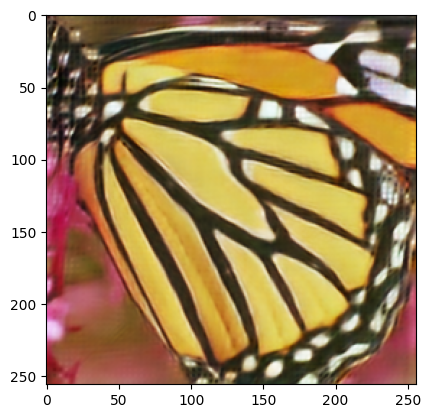

In [48]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False
)

In [49]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:02, 49.17it/s]
100it [00:01, 54.36it/s]


,PSNR,SSIM
SRGAN,24.135324,0.664656
Bicubic,23.045410,0.632868


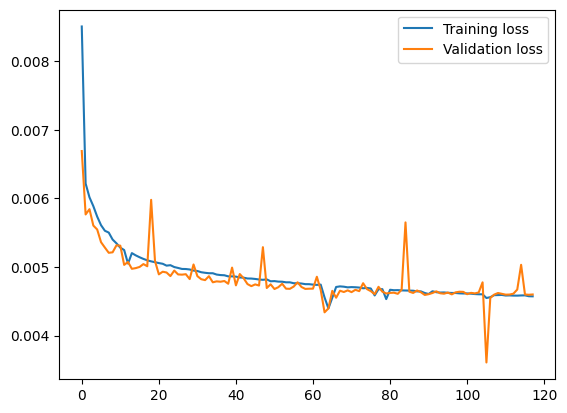

In [50]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(df['train_loss'], label='Training loss')
plt.plot(df['validation_loss'], label='Validation loss')
plt.legend()
plt.show()


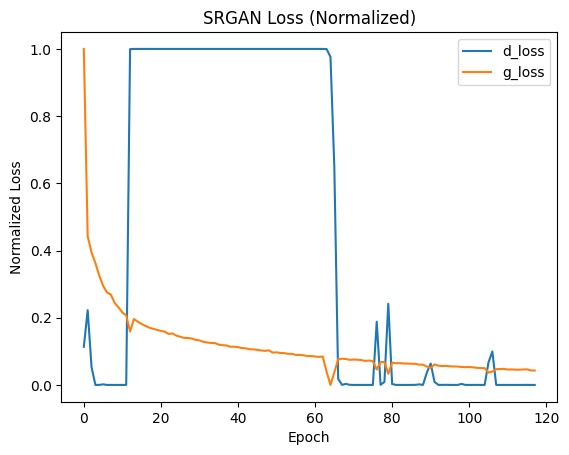

In [29]:
normalized_discriminator_losses = model_runner.normalize_data(discriminator_losses)
normalized_train_losses = model_runner.normalize_data(train_losses)

# Plot normalized data
plt.plot(normalized_discriminator_losses, label='d_loss')
plt.plot(normalized_train_losses, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('SRGAN Loss (Normalized)')
plt.legend()
plt.show()


In [51]:
# model_runner.save_model_df("./../results/srgan/dataframes/srgan_netG_follwing_paper_df_118_epochs_graphs_are_working.csv", df_to_save=df)

In [53]:
import pandas as pd
df_new = pd.read_csv("./../results/srgan/dataframes/srgan_netG_follwing_paper_df_118_epochs_graphs_are_working.csv")
df_new

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,315.062865,0.0002,0.008509,0.006692,0.113429
1,1,314.909172,0.0002,0.006218,0.005767,0.222434
2,2,315.473091,0.0002,0.006017,0.005844,0.053277
3,3,314.653120,0.0002,0.005888,0.005605,0.000086
4,4,314.797452,0.0002,0.005736,0.005548,0.000061
...,...,...,...,...,...,...
113,113,314.407282,0.0002,0.004583,0.004672,0.000002
114,114,314.227743,0.0002,0.004585,0.005032,0.000001
115,115,314.408258,0.0002,0.004587,0.004600,0.000118
116,116,314.572117,0.0002,0.004574,0.004596,0.000002


In [19]:
# model_runner.save_model_weights(netG, '../results/srgan/trained_models/srgan_netG_follwing_paper_118_epochs_graphs_are_working.pth')
# model_runner.save_model_weights(netD, '../results/srgan/trained_models/srgan_netD_follwing_paper_118_epochs_graphs_are_working.pth')

In [20]:
netG_test = Generator(UPSCALE_FACTOR).to('cpu')
netG_test.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG_follwing_paper_118_epochs_graphs_are_working.pth',  map_location=torch.device('cpu')))


<All keys matched successfully>

should_upsample MUST ONLY BE `TRUE` for SRCNN


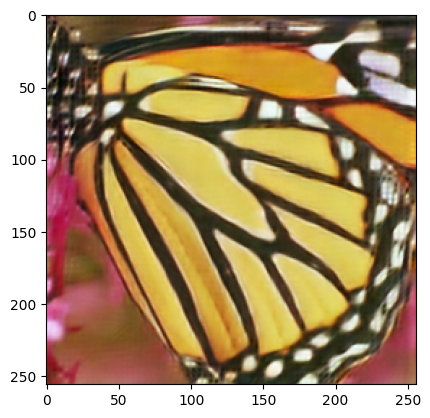

In [21]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG_test.to('cpu'),
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False,
    device='cpu'
)

In [22]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:12,  7.72it/s]
100it [00:02, 44.86it/s]


,PSNR,SSIM
SRGAN,24.13529,0.664658
Bicubic,23.04541,0.632869


In [32]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:13,  7.18it/s]
100it [00:02, 45.73it/s]


,PSNR,SSIM
SRGAN,22.76432,0.647017
Bicubic,23.04541,0.632869


In [27]:
model_f2_5 = SRCNN(f2=5).to(device)
model_f2_5.load_state_dict(torch.load('../results/srcnn/trained_models/model_f2_5.pth', map_location=torch.device('cpu')))

model_without_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_without_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth', map_location=torch.device('cpu')))


FileNotFoundError: [Errno 2] No such file or directory: './trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


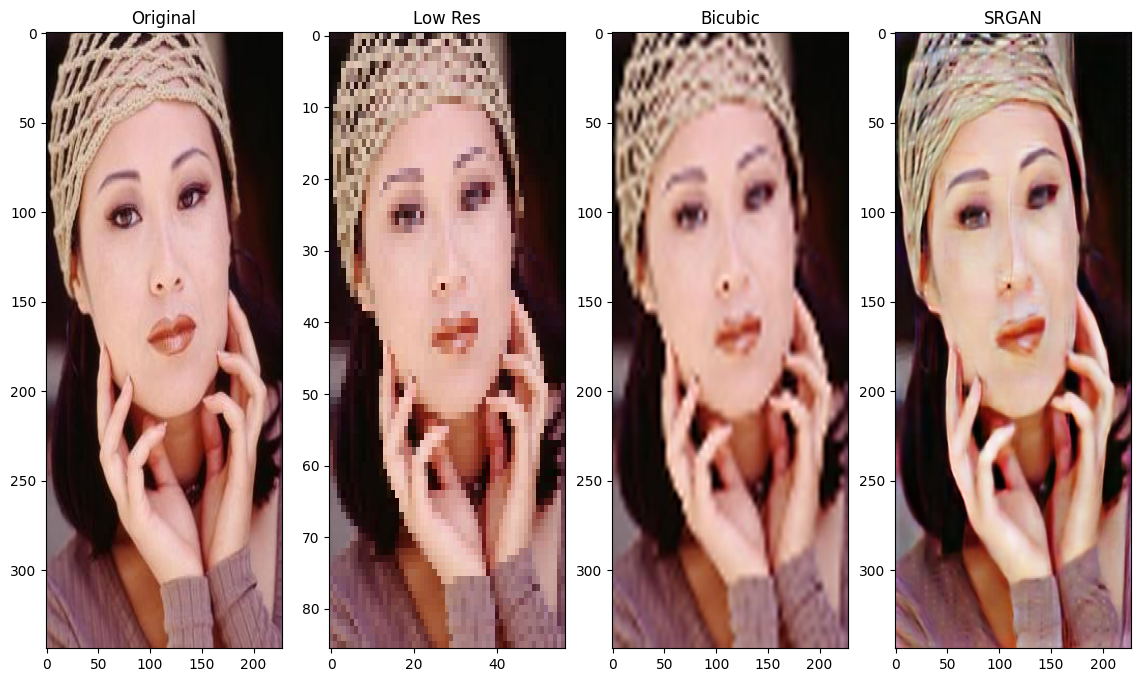

In [24]:
IMAGE_EXAMPLE = f"../datasets/Set5/woman.png"

image_helper.show_tensor_as_images_side_by_side(
    [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        # {
        #     "label": "SRCNN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model_f2_5,
        #         IMAGE_EXAMPLE,
        #         4
        #     )
        # },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                netG_test.to('cpu'),
                IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=test_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v4 (triangular)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v5 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v6 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=even_more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN *",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_epochs_less_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
    ],
)

In [30]:
model_runner.compare_models(
    [
        {
            "name": "SRCNN",
            "model": model_f2_5,
        },
        {"name": "DBPN without noise", "model": model_without_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

100it [00:04, 24.49it/s]
100it [01:23,  1.19it/s]
100it [00:07, 13.97it/s]
100it [00:01, 70.65it/s]


,PSNR,SSIM
SRCNN,23.475697,0.630280
DBPN without noise,9.236373,0.055450
SRGAN,24.347925,0.667682
Bicubic,23.045410,0.632869
